<a href="https://colab.research.google.com/github/nikhilbansal23/Amazon-Stock-Price-Prediction/blob/main/Amazon_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import uuid
from datetime import datetime
from scipy.stats import norm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [46]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data

In [47]:
test = pd.read_csv('/content/drive/MyDrive/Datasets/Amazon Stock Price Data/AMZN_test.csv')
train = pd.read_csv('/content/drive/MyDrive/Datasets/Amazon Stock Price Data/AMZN_train.csv')
val = pd.read_csv('/content/drive/MyDrive/Datasets/Amazon Stock Price Data/AMZN_val.csv')

In [48]:
print("Test data count "+str(len(test)))
print("Train data count "+str(len(train)))
print("Validation data count "+str(len(val)))

Test data count 504
Train data count 4781
Validation data count 503


In [49]:
train.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.43750,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.96875,1.979167,1.708333,1.729167,1.729167,14700000


In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4781 entries, 0 to 4780
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4781 non-null   object 
 1   Open       4781 non-null   float64
 2   High       4781 non-null   float64
 3   Low        4781 non-null   float64
 4   Close      4781 non-null   float64
 5   Adj Close  4781 non-null   float64
 6   Volume     4781 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 261.6+ KB


In [51]:
train['Date'] = pd.to_datetime(train['Date'])


In [52]:
# Find maximum and minimum dates
max_date = train['Date'].max()
min_date = train['Date'].min()

print("Maximum Date:", max_date)
print("Minimum Date:", min_date)

Maximum Date: 2016-05-13 00:00:00
Minimum Date: 1997-05-15 00:00:00


# Training Data

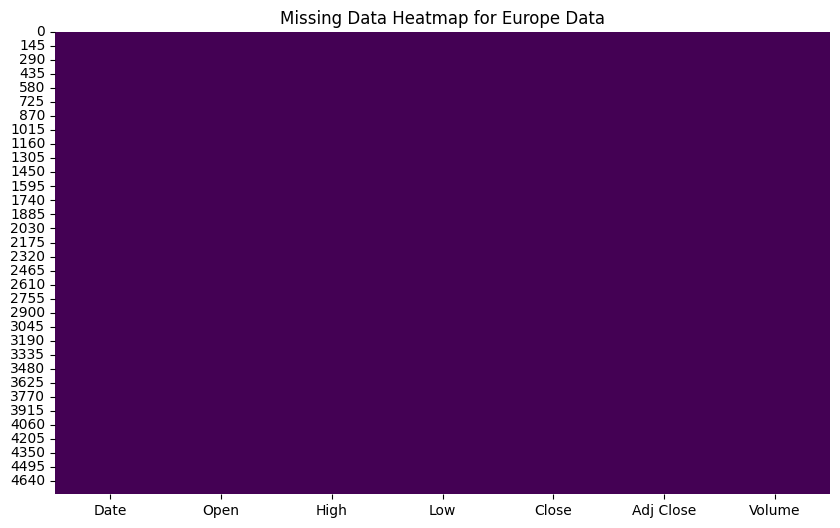

In [53]:
missing_data = train.isnull().sum()

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap for Europe Data')
plt.show()

In [54]:
# Exclude non-numeric columns
import plotly.figure_factory as ff
numerical_columns = train.select_dtypes(include=['float64', 'int64']).columns

# Create bell curve plots for numerical columns using Plotly Figure Factory
for col in numerical_columns:
    fig = ff.create_distplot([train[col]], [col], show_hist=False)
    fig.update_layout(title=f'Bell Curve for {col}', xaxis_title=col, yaxis_title='Density')
    fig.show()

In [55]:
# Filter data where 'High' and 'Low' are both less than 100
train = train[(train['High'] < 100) & (train['Low'] < 100)]


In [56]:
# Exclude non-numeric columns
import plotly.figure_factory as ff
numerical_columns =  train.select_dtypes(include=['float64', 'int64']).columns

# Create bell curve plots for numerical columns using Plotly Figure Factory
for col in numerical_columns:
    fig = ff.create_distplot([train[col]], [col], show_hist=False)
    fig.update_layout(title=f'Bell Curve for {col}', xaxis_title=col, yaxis_title='Density')
    fig.show()

In [57]:
# Extract date components
train['Day'] = train['Date'].dt.day
train['Month'] = train['Date'].dt.month
train['Year'] = train['Date'].dt.year
train['Weekday'] = train['Date'].dt.weekday  # 0: Monday, 6: Sunday

# Drop the original date column if not needed
train.drop('Date', axis=1, inplace=True)

In [58]:
# Create a new column 'Target' to indicate whether next day's closing price is higher than opening price
train['Target'] = (train['Close'].shift(-1) > train['Open']).astype(int)

In [59]:
train.head(5)

,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year,Weekday,Target
0,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,15,5,1997,3,0
1,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,16,5,1997,4,0
2,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,19,5,1997,0,0
3,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,20,5,1997,1,0
4,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,21,5,1997,2,0


In [60]:
train['Target'].value_counts()

1    1574
0    1545
Name: Target, dtype: int64

In [62]:
numerical_columns = ['Open', 'High', 'Close','Adj Close','Volume','Day','Month','Year','Weekday']
# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical columns in the DataFrame
train[numerical_columns] = scaler.fit_transform(train[numerical_columns])
train.head(5)

,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year,Weekday,Target
0,-1.553337,-1.559192,1.927083,-1.575310,-1.575310,7.095562,-0.084545,-0.465551,-1.690871,0.699436,0
1,-1.571998,-1.579500,1.708333,-1.584444,-1.584444,0.542278,0.029609,-0.465551,-1.690871,1.413993,0
2,-1.580292,-1.587623,1.625000,-1.585275,-1.585275,-0.437841,0.372070,-0.465551,-1.690871,-1.444234,0
3,-1.581536,-1.588435,1.635417,-1.588181,-1.588181,-0.510792,0.486224,-0.465551,-1.690871,-0.729677,0
4,-1.585268,-1.592497,1.375000,-1.596485,-1.596485,1.015981,0.600377,-0.465551,-1.690871,-0.015120,0


# **Test Data**

In [63]:
test.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-15,1587.800049,1587.800049,1565.219971,1576.119995,1576.119995,5077500
1,2018-05-16,1577.500000,1594.430054,1576.670044,1587.280029,1587.280029,2570600
2,2018-05-17,1580.560059,1594.040039,1573.000000,1581.760010,1581.760010,2147600
3,2018-05-18,1581.329956,1583.589966,1572.099976,1574.369995,1574.369995,2642600
4,2018-05-21,1585.000000,1592.050049,1575.000000,1585.459961,1585.459961,2925200


In [64]:
# Create a new column 'Target' to indicate whether next day's closing price is higher than opening price
test['Target'] = (test['Close'].shift(-1) > test['Open']).astype(int)

In [65]:
test['Date'] = pd.to_datetime(test['Date'])

In [66]:
# Find maximum and minimum dates
max_date = test['Date'].max()
min_date = test['Date'].min()

print("Maximum Date:", max_date)
print("Minimum Date:", min_date)

Maximum Date: 2020-05-14 00:00:00
Minimum Date: 2018-05-15 00:00:00


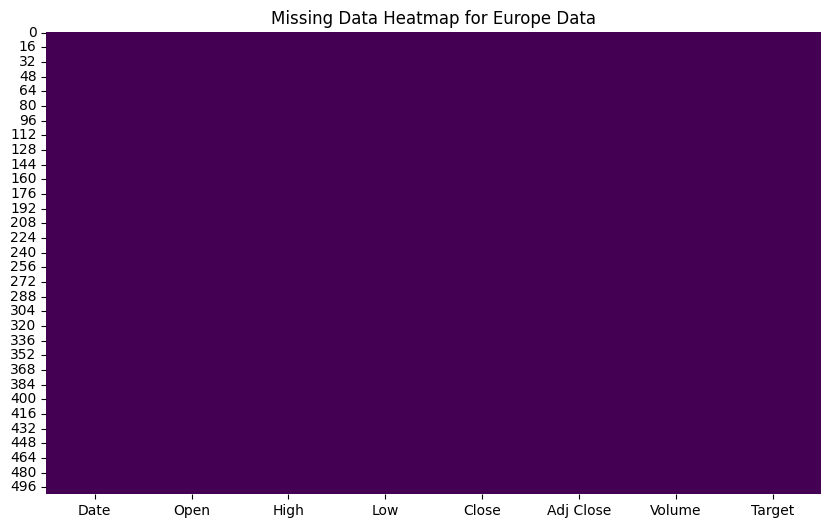

In [67]:
missing_data = test.isnull().sum()

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(test.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap for Europe Data')
plt.show()

In [68]:
# Exclude non-numeric columns
import plotly.figure_factory as ff
numerical_columns = test.select_dtypes(include=['float64', 'int64']).columns

# Create bell curve plots for numerical columns using Plotly Figure Factory
for col in numerical_columns:
    fig = ff.create_distplot([test[col]], [col], show_hist=False)
    fig.update_layout(title=f'Bell Curve for {col}', xaxis_title=col, yaxis_title='Density')
    fig.show()

In [69]:
# Extract date components
test['Day'] = test['Date'].dt.day
test['Month'] = test['Date'].dt.month
test['Year'] = test['Date'].dt.year
test['Weekday'] = test['Date'].dt.weekday  # 0: Monday, 6: Sunday

# Drop the original date column if not needed
test.drop('Date', axis=1, inplace=True)

In [70]:
# Separate numerical columns for scaling
numerical_columns = ['Open', 'High', 'Close','Adj Close','Volume','Day','Month','Year','Weekday']
# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical columns in the DataFrame
test[numerical_columns] = scaler.fit_transform(test[numerical_columns])
test.head(5)

,Open,High,Low,Close,Adj Close,Volume,Target,Day,Month,Year,Weekday
0,-1.326910,-1.425160,1565.219971,-1.390524,-1.390524,0.162936,0,-0.100545,-0.443129,-1.250653,-0.726602
1,-1.384791,-1.388145,1576.670044,-1.327930,-1.327930,-0.933737,1,0.013845,-0.443129,-1.250653,-0.015520
2,-1.367595,-1.390322,1573.000000,-1.358890,-1.358890,-1.118783,0,0.128234,-0.443129,-1.250653,0.695563
3,-1.363269,-1.448664,1572.099976,-1.400339,-1.400339,-0.902239,1,0.242623,-0.443129,-1.250653,1.406645
4,-1.342645,-1.401432,1575.000000,-1.338138,-1.338138,-0.778613,0,0.585791,-0.443129,-1.250653,-1.437685


# Validation Set

In [71]:
val.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-05-16,710.130005,713.250000,700.280029,710.659973,710.659973,5432900
1,2016-05-17,709.900024,714.469971,693.909973,695.270020,695.270020,5121400
2,2016-05-18,689.559998,702.539978,688.760010,697.450012,697.450012,4283200
3,2016-05-19,691.880005,699.400024,689.559998,698.520020,698.520020,3025600
4,2016-05-20,701.049988,707.239990,700.000000,702.799988,702.799988,2916200


In [72]:
val['Date'] = pd.to_datetime(val['Date'])

In [73]:
# Shift 'Close' price by one day to get the next day's closing price
val['Next_Day_Close'] = val['Close'].shift(-1)

# Create a new column 'Target' to indicate whether next day's closing price is higher than opening price
val['Target'] = (val['Next_Day_Close'] > val['Open']).astype(int)

# Drop rows where 'Next_Day_Close' or 'Target' for the last day is NaN (as there's no next day)
val = val.dropna(subset=['Next_Day_Close', 'Target'])

In [74]:
val.drop('Next_Day_Close', axis=1, inplace=True)

In [75]:
# Find maximum and minimum dates
max_date = val['Date'].max()
min_date = val['Date'].min()

print("Maximum Date:", max_date)
print("Minimum Date:", min_date)

Maximum Date: 2018-05-11 00:00:00
Minimum Date: 2016-05-16 00:00:00


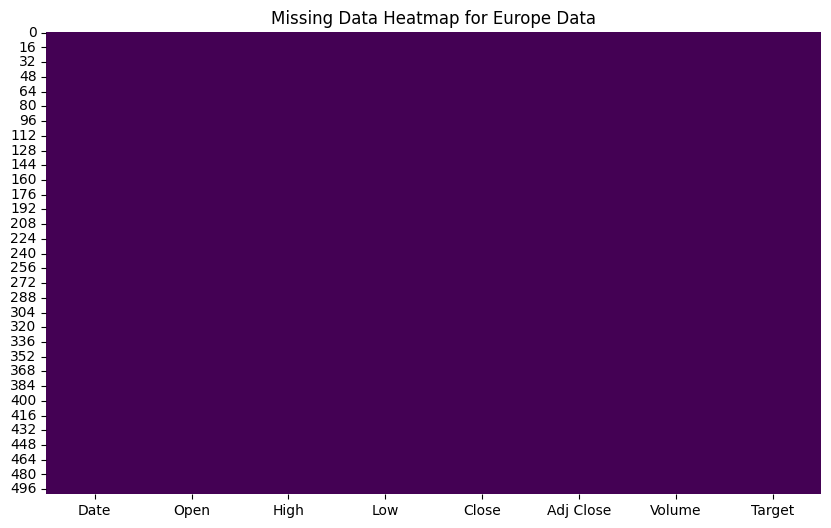

In [76]:
missing_data = val.isnull().sum()

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(val.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap for Europe Data')
plt.show()

In [77]:
# Exclude non-numeric columns
import plotly.figure_factory as ff
numerical_columns = val.select_dtypes(include=['float64', 'int64']).columns

# Create bell curve plots for numerical columns using Plotly Figure Factory
for col in numerical_columns:
    fig = ff.create_distplot([test[col]], [col], show_hist=False)
    fig.update_layout(title=f'Bell Curve for {col}', xaxis_title=col, yaxis_title='Density')
    fig.show()

In [78]:
# Extract date components
val['Day'] = val['Date'].dt.day
val['Month'] = val['Date'].dt.month
val['Year'] = val['Date'].dt.year
val['Weekday'] = val['Date'].dt.weekday  # 0: Monday, 6: Sunday

# Drop the original date column if not needed
val.drop('Date', axis=1, inplace=True)

In [79]:
# Separate numerical columns for scaling
# numerical_columns = test.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = ['Open', 'High', 'Close','Adj Close','Volume','Day','Month','Year','Weekday']
# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical columns in the DataFrame
val[numerical_columns] = scaler.fit_transform(val[numerical_columns])
val.head(5)

,Open,High,Low,Close,Adj Close,Volume,Target,Day,Month,Year,Weekday
0,-1.105587,-1.107273,700.280029,-1.104680,-1.104680,0.730655,0,0.032288,-0.4501,-1.24355,-1.464266
1,-1.106492,-1.102541,693.909973,-1.165408,-1.165408,0.580044,0,0.146432,-0.4501,-1.24355,-0.747133
2,-1.186561,-1.148821,688.760010,-1.156806,-1.156806,0.174771,1,0.260576,-0.4501,-1.24355,-0.030000
3,-1.177429,-1.161002,689.559998,-1.152584,-1.152584,-0.433282,1,0.374720,-0.4501,-1.24355,0.687134
4,-1.141331,-1.130588,700.000000,-1.135695,-1.135695,-0.486178,0,0.488864,-0.4501,-1.24355,1.404267


# **Model Building**

AUC near 0.5: Indicates the model's incapability to distinguish between classes.

AUC between 0.5 and 0.7: Represents a poor to fair discrimination capability.

AUC between 0.7 and 0.8: Suggests a good discrimination capability.

AUC between 0.8 and 0.9: Indicates a very good discrimination capability.

AUC above 0.9: Represents an excellent discrimination capability.

## **Random Forrest Classifier**

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Assuming 'X_train' and 'y_train' are your training data

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=50)
# Train the model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=50)

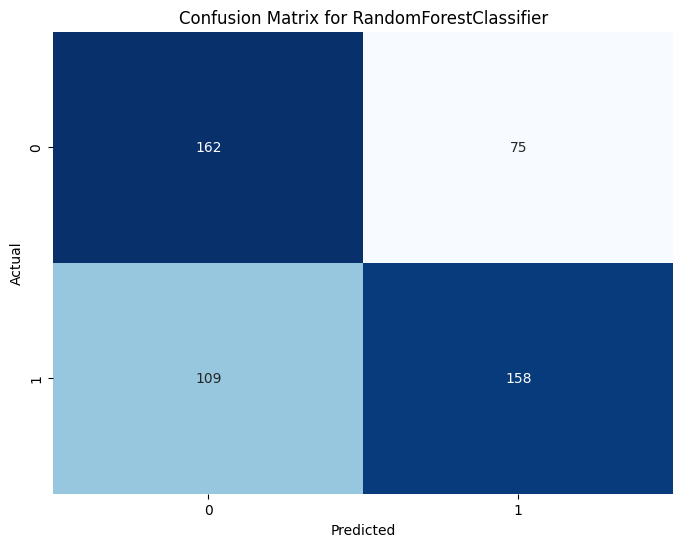

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       237
           1       0.68      0.59      0.63       267

    accuracy                           0.63       504
   macro avg       0.64      0.64      0.63       504
weighted avg       0.64      0.63      0.63       504



In [107]:
y_pred = rf_classifier.predict(X_test)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for RandomForestClassifier')
plt.show()

# Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

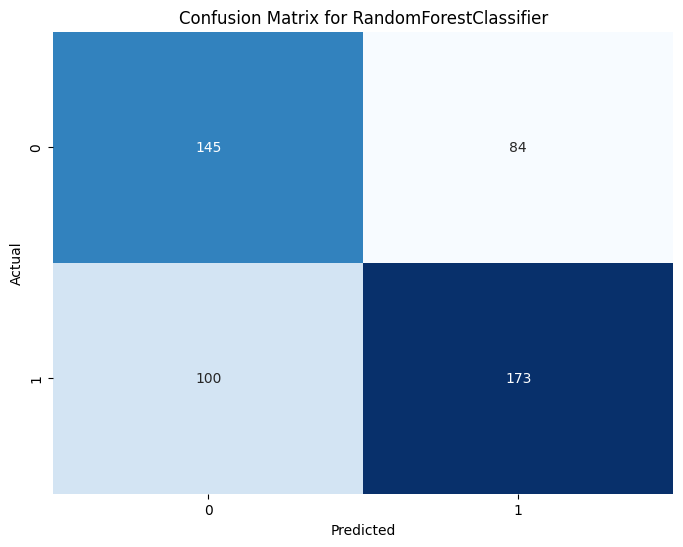

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       229
           1       0.67      0.63      0.65       273

    accuracy                           0.63       502
   macro avg       0.63      0.63      0.63       502
weighted avg       0.64      0.63      0.63       502



In [109]:
y_pred = rf_classifier.predict(X_val)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for RandomForestClassifier')
plt.show()

# Print classification report
class_report = classification_report(y_val, y_pred)
print("Classification Report:")
print(class_report)

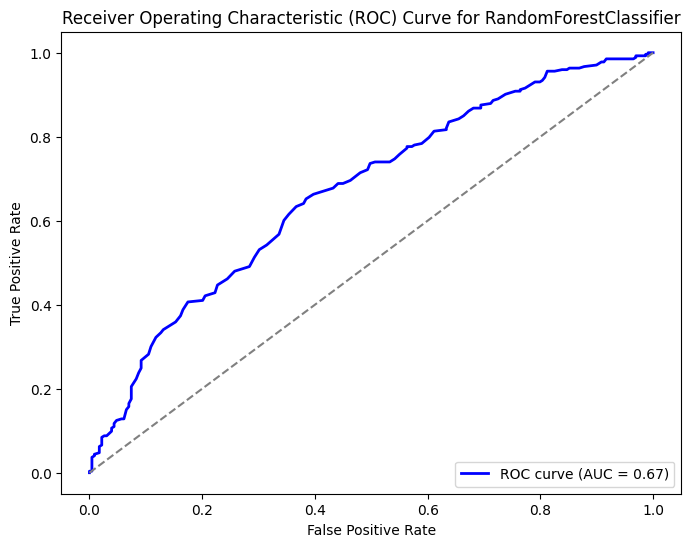

In [110]:
# Get predicted probabilities for the positive class (class 1)
y_probs = rf_classifier.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for RandomForestClassifier')
plt.legend(loc='lower right')
plt.show()


## **Gradient Boosting**

In [112]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Initialize Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Fit the model on the training data
gb_classifier.fit(X_train, y_train)

# Predict on the test set


GradientBoostingClassifier(random_state=42)

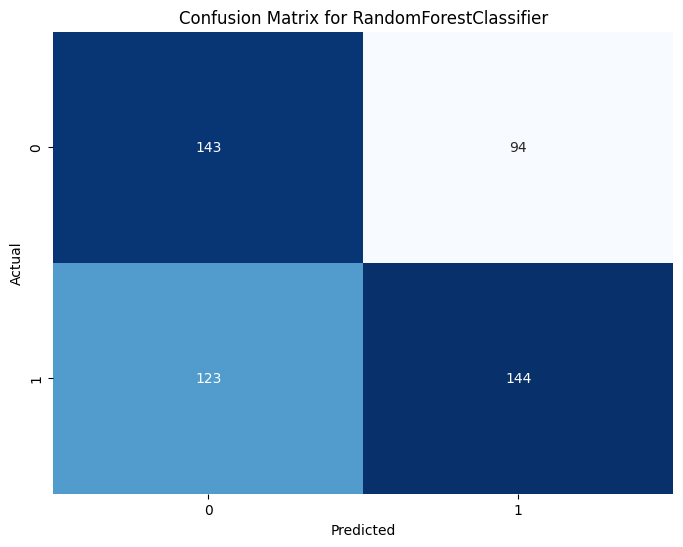

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.60      0.57       237
           1       0.61      0.54      0.57       267

    accuracy                           0.57       504
   macro avg       0.57      0.57      0.57       504
weighted avg       0.57      0.57      0.57       504



In [113]:
y_pred = gb_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for RandomForestClassifier')
plt.show()

# Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

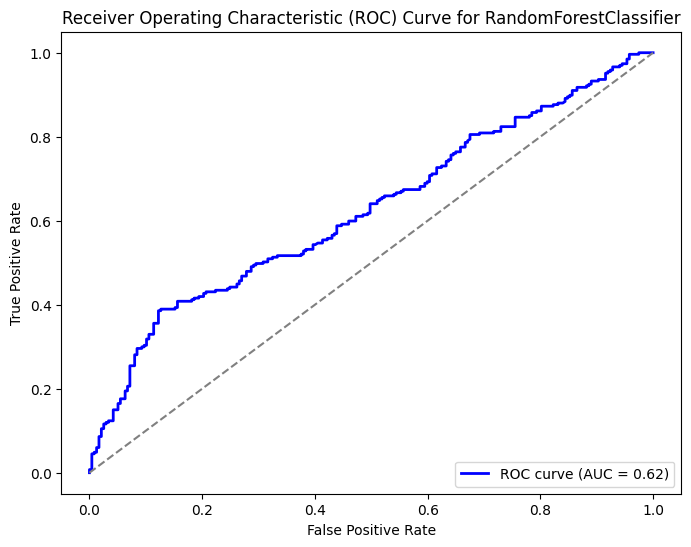

In [114]:
# Get predicted probabilities for the positive class (class 1)
y_probs = gb_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for RandomForestClassifier')
plt.legend(loc='lower right')
plt.show()


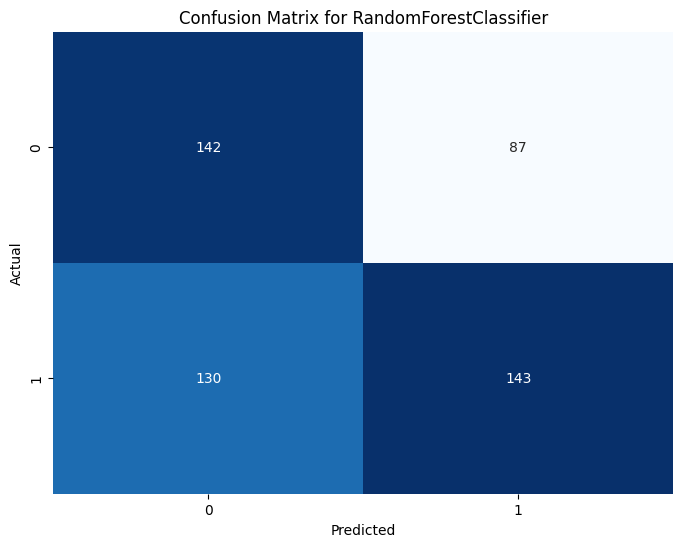

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.62      0.57       229
           1       0.62      0.52      0.57       273

    accuracy                           0.57       502
   macro avg       0.57      0.57      0.57       502
weighted avg       0.58      0.57      0.57       502



In [115]:
y_pred = gb_classifier.predict(X_val)
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for RandomForestClassifier')
plt.show()

# Print classification report
class_report = classification_report(y_val, y_pred)
print("Classification Report:")
print(class_report)

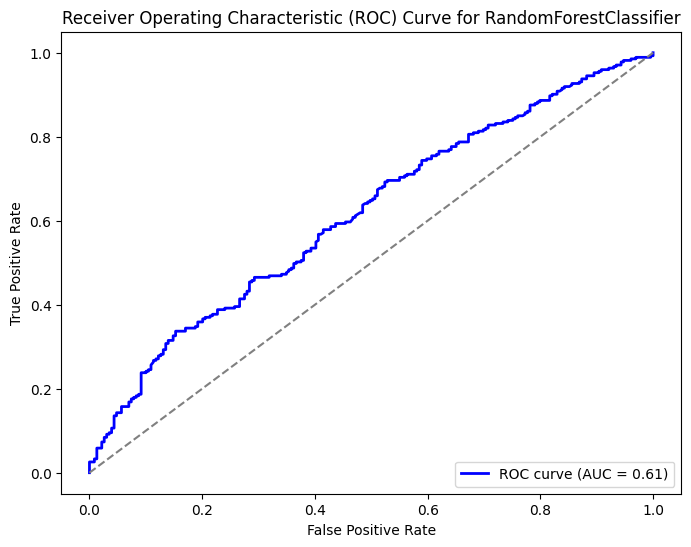

In [116]:
# Get predicted probabilities for the positive class (class 1)
y_probs = gb_classifier.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for RandomForestClassifier')
plt.legend(loc='lower right')
plt.show()


## Support Vector Classifier

In [120]:
from sklearn.svm import SVC

# Initialize Support Vector Classifier with probability=True
svc_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

# Fit the model on the training data
svc_classifier.fit(X_train, y_train)

SVC(probability=True, random_state=42)

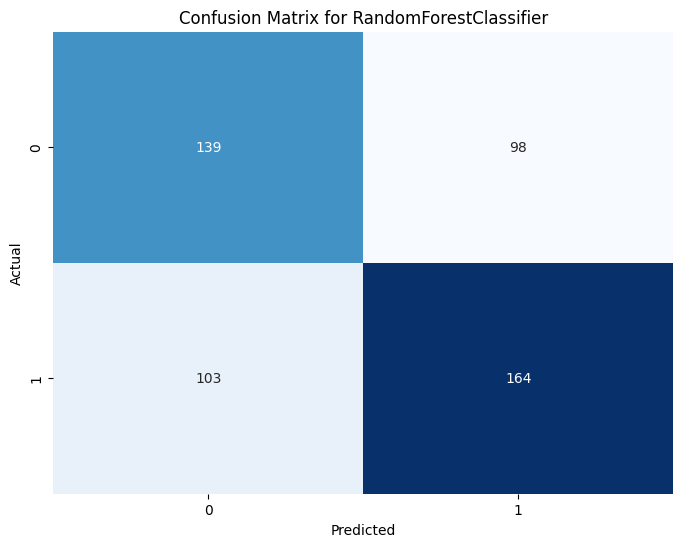

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       237
           1       0.63      0.61      0.62       267

    accuracy                           0.60       504
   macro avg       0.60      0.60      0.60       504
weighted avg       0.60      0.60      0.60       504



In [121]:
y_pred = svc_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for RandomForestClassifier')
plt.show()

# Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

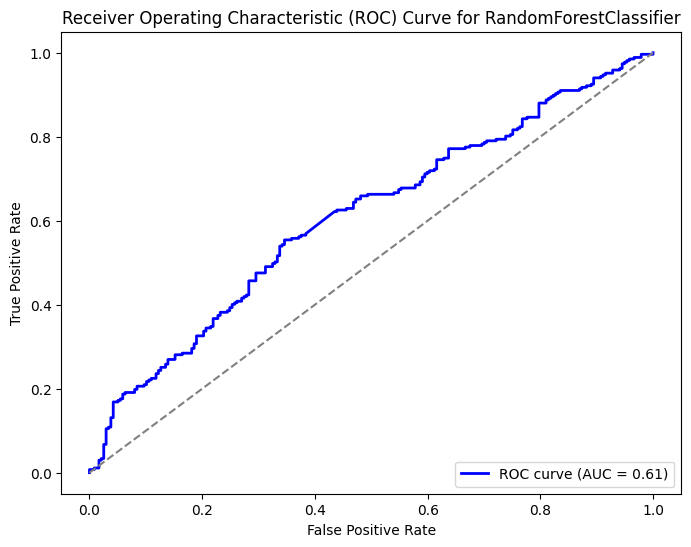

In [122]:
# Get predicted probabilities for the positive class (class 1)
y_probs = svc_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for RandomForestClassifier')
plt.legend(loc='lower right')
plt.show()


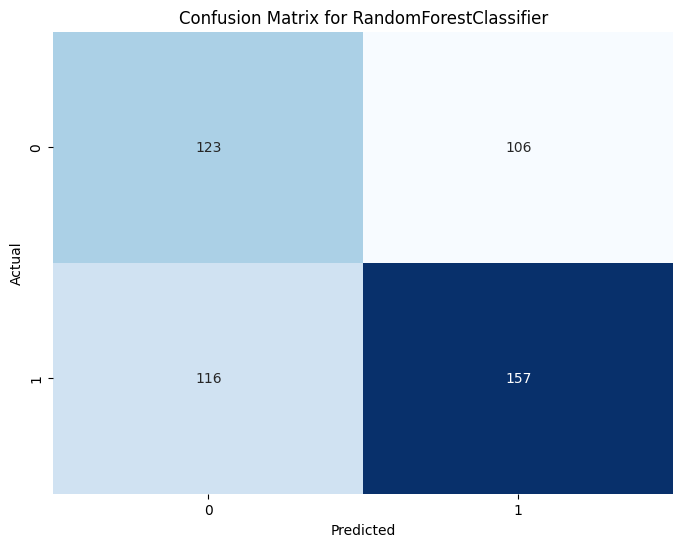

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.54      0.53       229
           1       0.60      0.58      0.59       273

    accuracy                           0.56       502
   macro avg       0.56      0.56      0.56       502
weighted avg       0.56      0.56      0.56       502



In [123]:
y_pred = svc_classifier.predict(X_val)
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for RandomForestClassifier')
plt.show()

# Print classification report
class_report = classification_report(y_val, y_pred)
print("Classification Report:")
print(class_report)

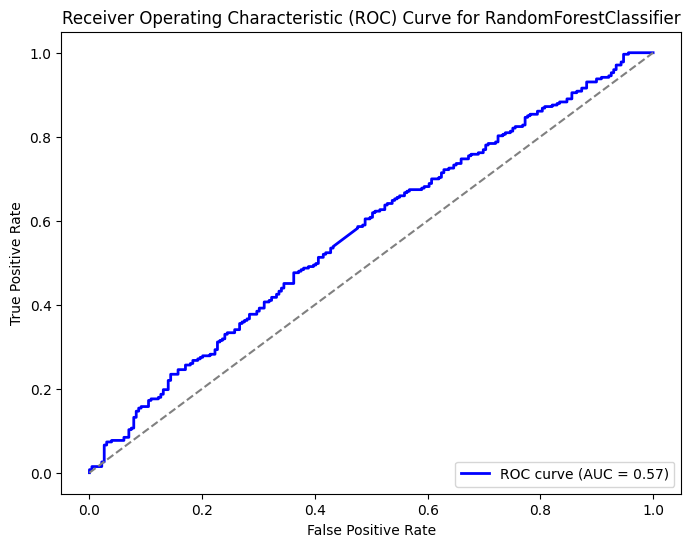

In [124]:
# Get predicted probabilities for the positive class (class 1)
y_probs = svc_classifier.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for RandomForestClassifier')
plt.legend(loc='lower right')
plt.show()
